# CPA and DPA on Instructions Implementation

## Prerequisites and definitions

In [15]:
%matplotlib notebook
import matplotlib.pylab as plt
import matplotlib.font_manager as font_manager
import numpy as np
import pandas as pd
import chipwhisperer as cw
from tqdm.notebook import trange
import time

###### definitions for compilation
SCOPETYPE     = 'CWNANO'
PLATFORM      = 'CWNANO'
CRYPTO_TARGET = 'NONE'
SS_VER        = 'SS_VER_1_1'

OPERATION     = 'BENCHMARK1'   # BENCHMARK1 BENCHMARK2 BENCHMARK3 BENCHMARK4 CURRENT
SIMPLE_INST   = 'NONE'           # LDR | STR | MOV | EOR | NONE
MODEL         = 'EOR'
RESPONSE_TEST = 'TRUE'          # for having the uart read 

N_TRACES      = 10000
N_SAMPLES     = 100             # Max value is scope.adc.samples Au total N_SAMPLES - 1
SAMPLES_START = 0
SAMPLES_END   = 100

#if OPERATION == 'BENCHMARK1' or OPERATION == 'BENCHMARK2' :
    #SAMPLES_START = 15
   # SAMPLES_END   = 35

#if OPERATION == 'BENCHMARK3' :
#    SAMPLES_START = 15
#    SAMPLES_END   = 80
#    if   SIMPLE_INST == 'LDR' : SAMPLES_END -=50
#    elif SIMPLE_INST == 'EOR' : SAMPLES_END -=45
#    elif SIMPLE_INST == 'STR' : SAMPLES_END -=45

MAX_ABS = 'FALSE'

###### definitions for test round 
TEST_ROUND    = 'TRUE'
N_ROUNDS      = 1
SUCCESS_CASE_THRESHOLD = 10 # Si l'hyp clé est parmi les top 10, je considère une réussite
GOOD_KEY      = 0xBE
GET_LAST_TRACE= 'FALSE'

###### Using the constant PT and Traces
DB_PLANT_TEXT = 'TRUE'
DB_TRACES     = 'TRUE' #It is important to check the correct result of the operation
NEW_CAPTURE   = 'FALSE'

###### definitions for DPA
SEL_FUNCTION  = 'HW'        # HW | LSB


In [2]:
SAMPLES_START

0

In [3]:
SAMPLES_END

100

## Save and load numpy Traces and PT

In [10]:
if DB_PLANT_TEXT == 'TRUE' :
    const_textin_array = np.load('./database/my_text_input.npy') #It has 10 000 PT of 16B
    print("You are using the database input text. Shape : ", const_textin_array.shape)
else : print("The input text will be generated automatically and randomly")

You are using the database input text. Shape :  (10000, 16)


In [11]:
if DB_TRACES == 'TRUE' :
    if OPERATION == 'BENCHMARK1' : const_trace_array = np.load('./bm1.npy')
    elif OPERATION == 'BENCHMARK2' : const_trace_array = np.load('./bm2.npy')
    elif OPERATION == 'BENCHMARK3' : const_trace_array = np.load('./bm3.npy')
    elif OPERATION == 'BENCHMARK4' : const_trace_array = np.load('./bm4.npy')
    else : print('Select a correct operation')
    print('You are using the database traces ', OPERATION, ' Shape : ', const_trace_array.shape)
else : print('You will get new traces')

You are using the database traces  BENCHMARK1  Shape :  (10000, 100)


In [ ]:
#%run "../../../Setup_Scripts/Setup_Generic.ipynb"
try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()
try:
    if SS_VER == "SS_VER_2_1":
        target_type = cw.targets.SimpleSerial2
    elif SS_VER == "SS_VER_2_0":
        raise OSError("SS_VER_2_0 is deprecated. Use SS_VER_2_1")
    else:
        target_type = cw.targets.SimpleSerial
except:
    SS_VER="SS_VER_1_1"
    target_type = cw.targets.SimpleSerial

try:
    target = cw.target(scope, target_type)
except:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope, target_type)
print("INFO: Found ChipWhisperer😍")
if "STM" in PLATFORM or PLATFORM == "CWLITEARM" or PLATFORM == "CWNANO":
    prog = cw.programmers.STM32FProgrammer

import time
time.sleep(0.05)
scope.default_setup()
scope.adc.samples = N_SAMPLES

def reset_target(scope):
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high_z'
    time.sleep(0.05)

### Compiling

In [13]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER" "$OPERATION"
cd ../../../../hardware/victims/firmware/cpa_ops
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 OPERATION=$4 -j

Building for platform CWNANO with CRYPTO_TARGET=NONE and OPERATION=BENCHMARK1
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Building for platform CWNANO with CRYPTO_TARGET=NONE and OPERATION=BENCHMARK1
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
make[1]: '.dep' is up to date.
Building for platform CWNANO with CRYPTO_TARGET=NONE and OPERATION=BENCHMARK1
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
arm-none-eabi-gcc.exe (GNU Arm Embedded Toolchain 10-2020-q4-major) 10.2.1 20201103 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Welcome to another exciting ChipWhisperer target build!!
.
Assembling: .././hal/stm32f0/stm32f0_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m0 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=objdir-CWNANO/stm32f0_startup.lst -I.

In [9]:
cw.program_target(scope, prog, "../../../../hardware/victims/firmware/cpa_ops/simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F03xx4/03xx6
Extended erase (0x44), this can take ten seconds or more
Attempting to program 4851 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4851 bytes


## Instruction Trace Capture

In [2]:
def get_traces() :
    ktp = cw.ktp.Basic()
    textin_array = []
    textout_array = [] 
    trace_array = []
    key, text = ktp.next()
    
    for i in trange(N_TRACES, desc='Capturing traces'):
        scope.arm()
        if DB_PLANT_TEXT != 'TRUE' : target.simpleserial_write('p', text)
        else : target.simpleserial_write('p', const_textin_array[i])
        ret = scope.capture() #returns ‘True’ if timeout, ‘False’ if no timeout
        if ret:
            print('Target timed out!')
            continue
        if RESPONSE_TEST == 'TRUE' : textout_array.append(target.simpleserial_read('r', 16))
        trace_array.append(scope.get_last_trace())
        if DB_PLANT_TEXT != 'TRUE' :
            textin_array.append(text)
        key, text = ktp.next()
        splot.update(scope.get_last_trace())

    trace_array = np.array(trace_array)
    if RESPONSE_TEST == 'TRUE' : textout_array = np.array(textout_array)
    if DB_PLANT_TEXT != 'TRUE' : textin_array = np.array(textin_array)
    
    if RESPONSE_TEST == 'TRUE' : 
        return trace_array, textin_array, textout_array
    else :
        return trace_array, textin_array, 'NULL'

## Help functions

**reponse_test(textin_array, textout_array)** : Test the operation result on the CPU was done well by comparing with the UART response. <br>
**selecting_samples(trace_array)** : selects exactly the samples you want from the original curve.<br>
**show_courbes(trace_array_selected)**: Shows three curves from the set of curves in the parameter. len(trace_array_selected) >=10.<br>
**plt_time_corr(key_hyp, correla_array, s_trace)**: plot the correlation graph.

In [3]:
def reponse_test(textin_array, textout_array) :
    #print(target, '\n') # uncomment if you want to see the values
    #print("textin_array", textin_array)
    #print("textout_array", textout_array)
    corrects = 0;

    for i in range(N_TRACES):
        if MODEL == 'EOR' :
            if(textout_array[i][0] == textin_array[i][0]^GOOD_KEY) :
                corrects = corrects + 1;
            else : 
                print('indice de erro', i)
                print('textin_array do erro', textin_array[i])
                print('textout_array do err', textout_array[i])
    #assert (corrects == N_TRACES), f"you achieved {corrects} over {N_TRACES} UART expected results"
    print(f"you achieved {corrects} over {N_TRACES} UART expected results")
    #print("OK")

def selecting_samples(trace_array) :
    trace_array_s = np.asarray(trace_array)[:, SAMPLES_START:SAMPLES_END]
    return trace_array_s

def show_courbes(trace_array_selected) :
    plt.rcParams['figure.figsize']=(8,4)
    plt.figure()
    plt.xlabel('Sample', fontsize = 8)
    plt.ylabel('Power', fontsize = 8)
    for i in range (N_TRACES) :
        plt.plot(trace_array_selected[i, :])
    #plt.plot(trace_array_selected[5, 0:100], '#FFAF35') ##389FE8 plt 1
    #plt.plot(trace_array_selected[10, 0:100], '#744FFF')
    plt.grid()
    #plt.title('Power traces of 3 different plain texts', fontsize = 12);
    #plt.title('Power traces of 3 different plain texts', fontsize = 12);
    plt.legend(['PT 1', 'PT 2', 'PT 3'], loc=0, fontsize = 9);
    plt.show()
    
def plt_time_corr(key_hyp, correla_array, s_trace) :
    plt.rcParams['figure.figsize']=(8,4)
    fig = plt.figure();

    ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4]) # axe up
    ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4]) # axe down
    
    ax1.set_ylabel('Pearson $r_{xy}$')
    ax2.set_ylabel('Power')
    ax2.set_xlabel('Sample')

    ax1.plot((correla_array), color='#C8B6C9')
    ax1.plot((correla_array[:,key_hyp]), color='#BD6D8D', label='Hyp key 0x%02X'%(key_hyp))
    ax1.plot((correla_array[:,GOOD_KEY]), color='#660B4C', label='Real key 0x%02X'%(GOOD_KEY)) # or #8E0F6B

    ax2.plot((s_trace[22]), color='#6DA932')  
    mask = np.isnan(correla_array) # to remove nan
    preprocessing = correla_array
    preprocessing[mask] = 0
    
    if MAX_ABS == 'TRUE' :    
        good_key_line = np.argmax(np.abs(preprocessing[:,GOOD_KEY])) #np.argmax(preprocessing[:,GOOD_KEY])
        hyp_key_line = np.argmax(np.abs(preprocessing[:,key_hyp]))
    else :
        good_key_line = np.argmax(preprocessing[:,GOOD_KEY]) #np.argmax(preprocessing[:,GOOD_KEY])
        hyp_key_line = np.argmax(preprocessing[:,key_hyp])

    ax1.axvline(good_key_line, color='#660B4C', linestyle='-.') # Traça a linha no eixo superior
    ax2.axvline(good_key_line, color='#660B4C', linestyle='-.') # Traça a linha no eixo inferior

    ax1.axvline(hyp_key_line, color='#BD6D8D', linestyle='-') # Traça a linha no eixo superior
    ax2.axvline(hyp_key_line, color='#BD6D8D', linestyle='-') # Traça a linha no eixo inferior
    
    ax1.legend(fontsize = 9, loc =4)
    plt.show()
    
def plt_time_dpa(key_hyp, correla_array, s_trace) :
    plt.rcParams['figure.figsize']=(8,4)
    fig = plt.figure();

    ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4]) # axe up
    ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4]) # axe down
    
    ax1.set_ylabel('T_Test')
    ax2.set_ylabel('Power')
    ax2.set_xlabel('Sample')

    ax1.plot((correla_array), color='#C8B6C9')
    ax1.plot((correla_array[:,key_hyp]), color='#BD6D8D', label='Hyp key 0x%02X'%(key_hyp))
    ax1.plot((correla_array[:,GOOD_KEY]), color='#660B4C', label='Real key 0x%02X'%(GOOD_KEY)) # or #8E0F6B
    
    ax1.axhline(y=5,  color='#4D4D4D', linewidth=0.5, linestyle='--')
    ax1.axhline(y=-5, color='#4D4D4D', linewidth=0.5, linestyle='--')
    
    ax2.plot((s_trace[22]), color='#6DA932')  
    mask = np.isnan(correla_array) # to remove nan
    preprocessing = correla_array
    preprocessing[mask] = 0
    
    if MAX_ABS == 'TRUE' :    
        good_key_line = np.argmax(np.abs(preprocessing[:,GOOD_KEY])) #np.argmax(preprocessing[:,GOOD_KEY])
        hyp_key_line = np.argmax(np.abs(preprocessing[:,key_hyp]))
    else :
        good_key_line = np.argmax(preprocessing[:,GOOD_KEY]) #np.argmax(preprocessing[:,GOOD_KEY])
        hyp_key_line = np.argmax(preprocessing[:,key_hyp])

    ax1.axvline(good_key_line, color='#660B4C', linestyle='-.') # Traça a linha no eixo superior
    ax2.axvline(good_key_line, color='#660B4C', linestyle='-.') # Traça a linha no eixo inferior

    ax1.axvline(hyp_key_line, color='#BD6D8D', linestyle='-') # Traça a linha no eixo superior
    ax2.axvline(hyp_key_line, color='#BD6D8D', linestyle='-') # Traça a linha no eixo inferior
    
    ax1.legend(fontsize = 9, loc =4)
    plt.show()

## Instruction Model, Hamming Weight and CPA

In [4]:
######################## Instruction Model #######################

if MODEL == 'ADD' :
    print('ADD selected')
    def op_internal(inputdata, s):
        return (inputdata + s) & 0xFF
    
if MODEL == 'EOR' :
    print('EOR selected')
    def op_internal(inputdata, s):
        return (inputdata ^ s)
    
######################## Hamming Weight ##########################
    
HW = [bin(a).count('1') for a in range (0, 256)]  


def calcular_distancias():
    distancias = []
    for i in range(256):
        linha = []
        for j in range(256):
            d = HD(i, j)
            linha.append(d)
        distancias.append(linha)
    return distancias

def show_model() :
    s_be = []
    for i in range (0, 256):
        s_be.append(op_internal(i , 0xBE))

    s_41 = []
    for i in range (0, 256):
        s_41.append(op_internal(i , 0x41))
    
    plt.figure()
    plt.plot(s_be)
    plt.plot(s_41)
    plt.xlabel('Plaint text', fontsize = 8)
    plt.ylabel('Result ', fontsize = 8)
    plt.title(f'{OPERATION}(PT, secret) with 2 different secrets', fontsize = 10);
    plt.legend(['secret 0xBE', 'secret 0x41'], loc=0, fontsize = 7);
    plt.grid()
    plt.show()

######################## Functions CPA Algorithm ###############

def mean(X):
    return np.mean(X, axis = 0)

def std_dev(X, X_bar): # X_bar is the mean
    return np.sqrt( np.sum( (X - X_bar)**2,axis=0) )
    
def cov(X, X_bar, Y, Y_bar):
    return np.sum( (X-X_bar)*(Y-Y_bar), axis=0 )

EOR selected


## CPA Attack Implementaiton

In [5]:
def CPA_attack(trace_array_selected, textin_array) :
    sorted_args = [0] * 256
    key_guess   = []
    maxcpa_abs  = [0] * 256
    maxcpa      = [0] * 256
    time_correlation_array = np.empty((256,SAMPLES_END - SAMPLES_START ))
    # we don't need to rerun the mean and std dev calculations for each key guess
    t_bar = mean(trace_array_selected) 
    o_t = std_dev(trace_array_selected, t_bar)

    for kguess in range(0, 256):
        hws = np.array([[HW[op_internal(textin[0],kguess)] for textin in textin_array]]).transpose()
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        correlation = cov(trace_array_selected, t_bar, hws, hws_bar)
        cpaoutput = correlation/(o_t*o_hws)
        maxcpa[kguess] = max((cpaoutput)) # J'ai pas pris la valeur max(abs(cpaoutput))
        maxcpa_abs[kguess] = max(abs(cpaoutput))
        
        time_correlation_array[kguess] = cpaoutput
        
        if MAX_ABS == 'TRUE' : sorted_args = np.argsort(maxcpa_abs)[::-1]
        else :                 sorted_args = np.argsort(maxcpa)[::-1]
        #Keep most likely
        key_guess.append(sorted_args[0])
    
    if MAX_ABS == 'TRUE' : 
        guess = np.argmax(maxcpa_abs)
        guess_corr = max(maxcpa_abs)
    else :
        guess = np.argmax(maxcpa)
        guess_corr = max(maxcpa)  
        
    key_index = sorted_args.tolist().index(GOOD_KEY)
    if MAX_ABS == 'TRUE' : key_corr = maxcpa_abs[GOOD_KEY]
    else : key_corr = maxcpa[GOOD_KEY]
    print('\n * The correct key %02X = %d is in position %d with a correlation = %f'%(GOOD_KEY, GOOD_KEY, key_index+1,key_corr))
    
    for i in range(0, 10):
        g = sorted_args[i]
        if MAX_ABS == 'TRUE' : print('   %i.\t%02X = \t %f'%(i+1, g, maxcpa_abs[g]))
        else : print('   %i.\t%02X = \t %f'%(i+1, g, maxcpa[g]))
    
    return sorted_args[0], key_index, key_corr, time_correlation_array.transpose()

In [6]:
splot = cw.StreamPlot()
splot.plot()

:DynamicMap   []
   :Curve   [x]   (y)

## CPA TEST 1

In [14]:
N_TRACES      = 10000
if OPERATION == 'BENCHMARK1' :
    SAMPLES_START = 25
    SAMPLES_END   = 49
elif OPERATION == 'BENCHMARK2' :
    SAMPLES_START = 25
    SAMPLES_END   = 48
elif OPERATION == 'BENCHMARK3' or OPERATION == 'BENCHMARK4' :
    SAMPLES_START = 50
    SAMPLES_END   = 65
    print("You selected : ", OPERATION)
    
MAX_ABS       = 'TRUE'
NEW_CAPTURE = 'FALSE'


sorted_key_corr = []
n_success = 0
n_success_top1 = 0
key_index = 0
key_corr = 0.0
#0 to N_ROUNDS-1
for i in range (N_ROUNDS) :

    if NEW_CAPTURE == 'TRUE' :
        if DB_PLANT_TEXT == 'TRUE' :
            trace_array, _, textout_array = get_traces() 
            textin_array = const_textin_array[0:N_TRACES, :]
        else :
            trace_array, textin_array, textout_array = get_traces()
  
        trace_selected_CPA_10_000 = selecting_samples(trace_array)
    
        if RESPONSE_TEST == 'TRUE' : reponse_test(textin_array, textout_array)
            
    else :
        trace_array = const_trace_array[0:N_TRACES, :]
        trace_selected_CPA_10_000 = selecting_samples(trace_array)
        textin_array = const_textin_array[0:N_TRACES, :]
        
    key_hyp, key_index, key_corr, corr_array = CPA_attack(trace_selected_CPA_10_000, textin_array)
    
    if key_index < SUCCESS_CASE_THRESHOLD:
        n_success = n_success + 1
    if key_index < 2:
        n_success_top1 = n_success_top1 + 1
        
    sorted_key_corr.append(key_corr)

###### Result 
print('\n \n * Data shapes : ')
print('trace_array : ', trace_array.shape)
print('textin_array : ', textin_array.shape)
print('trace_array_selected : ', trace_selected_CPA_10_000.shape)
print('\n \n * Round results : ')
print('On a', n_success, 'sur', N_ROUNDS, 'successes', ', avec le SUCCESS_CASE_THRESHOLD = ', SUCCESS_CASE_THRESHOLD)
print('Et avec la corrélation la plus élevée', n_success_top1, 'sur', N_ROUNDS, 'fois')
print('The min corr for %02X is = %f and the max corr = %f'%(GOOD_KEY, min(sorted_key_corr), max(sorted_key_corr)) )  

NameError: name 'selecting_samples' is not defined

<IPython.core.display.Javascript object>


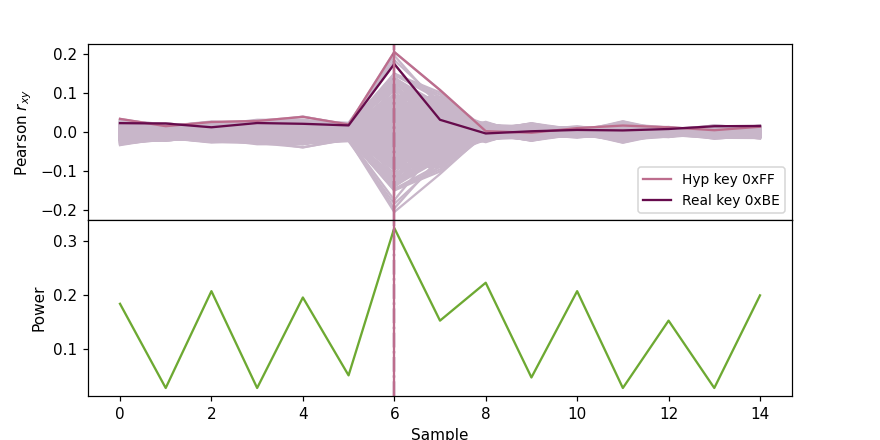

In [21]:
plt.rcParams['figure.figsize']=(8,6)
plt_time_corr(key_hyp, corr_array, trace_selected_CPA_10_000)

<IPython.core.display.Javascript object>


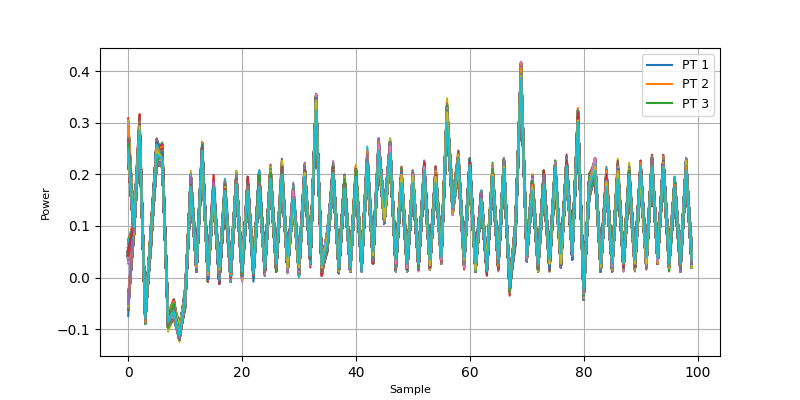

(10000, 100)


In [38]:
show_courbes(trace_array)
print(trace_array.shape)

<IPython.core.display.Javascript object>


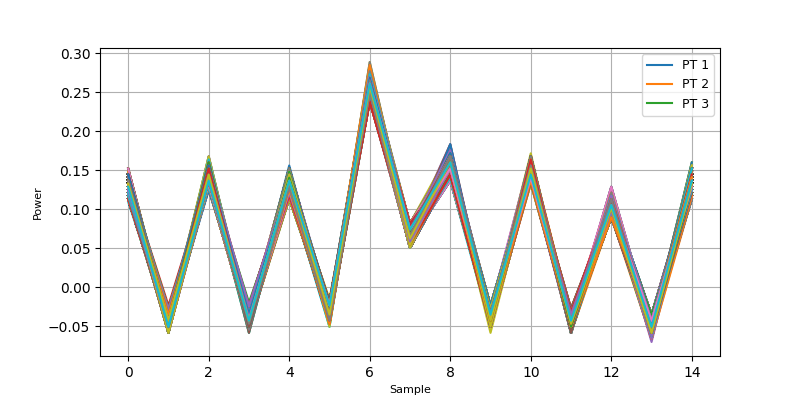

(10000, 15)


In [32]:
show_courbes(trace_selected_CPA_10_000)
print(trace_selected_CPA_10_000.shape)

## Scared

In [22]:
import estraces 
import scared

key_np_array = np.ones((N_TRACES,16),dtype=np.uint8)
for i in range(N_TRACES):
    key_np_array[i,0]=GOOD_KEY
ths = estraces.read_ths_from_ram(samples=trace_selected_CPA_10_000, **{'plaintext': const_textin_array[0:N_TRACES,:], 'key' : key_np_array})
print(ths)
container = scared.Container(ths)



Trace Header Set:
Name.............: RAM Format THS
Reader...........: RAM reader with 10000 traces. Samples shape: (10000, 15) and metadatas: ['plaintext', 'key']
plaintext........: uint8
key..............: uint8



In [23]:
attack_selection_function = scared.aes.selection_functions.encrypt.FirstAddRoundKey()

attack_cpa = scared.CPAAttack(
        selection_function=attack_selection_function,
        model=scared.HammingWeight(),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//10    
    )
attack_cpa.run(container)

In [24]:
found_key = attack_cpa.scores.argmax(0).squeeze()
found_key

array([255,  80, 115, 244,   3,  81,  58, 224, 252, 237, 221,  60,  57,
        52, 203,  15], dtype=int64)

In [25]:
attack_cpa.results.shape

(256, 16, 15)

<IPython.core.display.Javascript object>


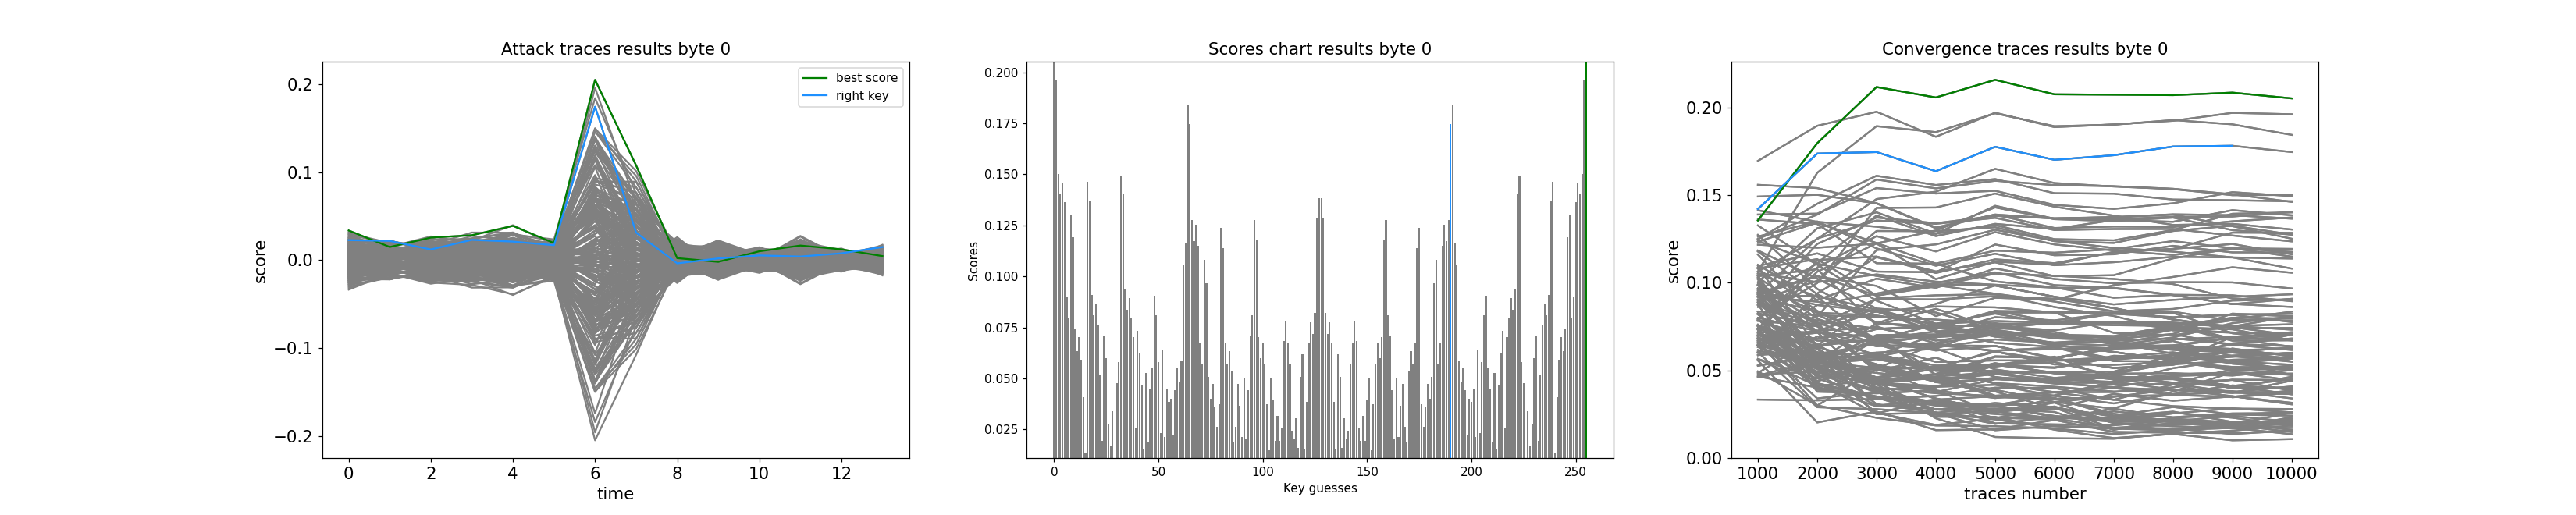

Best guess for byte 0 = 0xff
Correct guess for byte : 0=0xbe


In [27]:
import aLibrary.attack_results_scared_dist as scared_attack_result
attack_result = scared_attack_result.attack_results_scared_dist(attack_cpa)
plt.rcParams['figure.figsize']=(30,6)
plt.figure();
attack_result.plot(0, ths.key[0])

In [ ]:
ths.key[0]

## DPA

Its effectiveness depends on the nature of the cryptographic operation being attacked.
DPA is most effective when attacking non-linear cryptographic operations, such as substitution operations (S-boxes). However, DPA can also be used to attack linear cryptographic operations, such as XOR.

In [162]:
OPERATION = 'ALL_SEPARATE' 
DB_TRACES = 'TRUE'

if DB_TRACES == 'TRUE' :
    if OPERATION == 'BENCHMARK1' : const_trace_array = np.load('./bm1.npy')
    elif OPERATION == 'BENCHMARK2' : const_trace_array = np.load('./bm2.npy')
    elif OPERATION == 'CURRENT' : const_trace_array = np.load('./bm3.npy')
    elif OPERATION == 'ALL_SEPARATE' : const_trace_array = np.load('./bm4.npy')
    else : print('Select a correct operation')
    print('You are using the database traces ', OPERATION, ' Shape : ', const_trace_array.shape)
else : print('You will get new traces')
    
N_TRACES      = 10000
if OPERATION == 'BENCHMARK1' :
    SAMPLES_START = 25
    SAMPLES_END   = 49
elif OPERATION == 'BENCHMARK2' :
    SAMPLES_START = 25
    SAMPLES_END   = 48
elif OPERATION == 'CURRENT' or OPERATION == 'ALL_SEPARATE' :
    SAMPLES_START = 26
    SAMPLES_END   = 90
    
trace_selected_DPA_10_000 = const_trace_array[0:N_TRACES, :]
trace_selected_DPA_10_000 = selecting_samples(trace_selected_DPA_10_000)
print('New selected shape : ', trace_selected_DPA_10_000.shape)

You are using the database traces  ALL_SEPARATE  Shape :  (10000, 100)
New selected shape :  (10000, 64)


In [163]:
def mean_t_test(a, b):
    t_stat = 0
    s_pooled = 0 
    n1 = len(a)
    n2 = len(b)
    mean1 = np.asarray(a).mean(axis=0)
    mean2 = np.asarray(b).mean(axis=0)
    var1 = np.var(a, axis=0, ddof=1)
    var2 = np.var(b, axis=0, ddof=1)
    s_pooled = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    t_stat = (mean1 - mean2) / (s_pooled * np.sqrt(1/n1 + 1/n2))
    return (t_stat)

In [164]:
time_dpa_array = np.empty((256,SAMPLES_END - SAMPLES_START ))
ttest_diffs = np.zeros(256)
for guess in range(0, 256):
    one_list = []
    zero_list = []

    for trace_index in range(N_TRACES): # loop for the 2500 traces that we have
        hypothetical_leakage = op_internal(const_textin_array[trace_index][0], guess)
        
        if SEL_FUNCTION == 'HW' :
            h = HW[hypothetical_leakage]
            if h > 4 : one_list.append(trace_selected_DPA_10_000[trace_index])
            else: zero_list.append(trace_selected_DPA_10_000[trace_index]) 
        else:
            if hypothetical_leakage & 0b00000001 : one_list.append(trace_selected_DPA_10_000[trace_index])
            else : zero_list.append(trace_selected_DPA_10_000[trace_index])
                
    time_dpa_array[guess] = (mean_t_test(one_list, zero_list))        
    ttest_diffs[guess] = np.max(mean_t_test(one_list, zero_list)) #t test

sorted_args = np.argsort(ttest_diffs)[::-1]
time_dpa_array = time_dpa_array.transpose()
###### Result
print('\n \n * The highest value of the DPA is %f referring to key : 0x%02X'%(np.max(ttest_diffs), np.argmax(ttest_diffs)))
for i in range(0, 10):
    g = sorted_args[i]
    print('   %02X - Diff = %f'%(g, ttest_diffs[g]))

key_hyp_DPA = sorted_args[0];
print('\n \n * Selection function shapes : ', 'one_list', len(one_list), 'zero_list', len(zero_list))
print('Traces shape : ', trace_selected_DPA_10_000.shape)


 
 * The highest value of the DPA is 19.583184 referring to key : 0xBE
   BE - Diff = 19.583184
   00 - Diff = 19.002090
   DE - Diff = 17.016104
   FF - Diff = 16.741775
   FE - Diff = 15.853822
   AE - Diff = 15.719135
   04 - Diff = 15.099438
   05 - Diff = 14.965280
   7E - Diff = 14.837415
   01 - Diff = 14.733975

 
 * Selection function shapes :  one_list 3575 zero_list 6425
Traces shape :  (10000, 64)


<IPython.core.display.Javascript object>


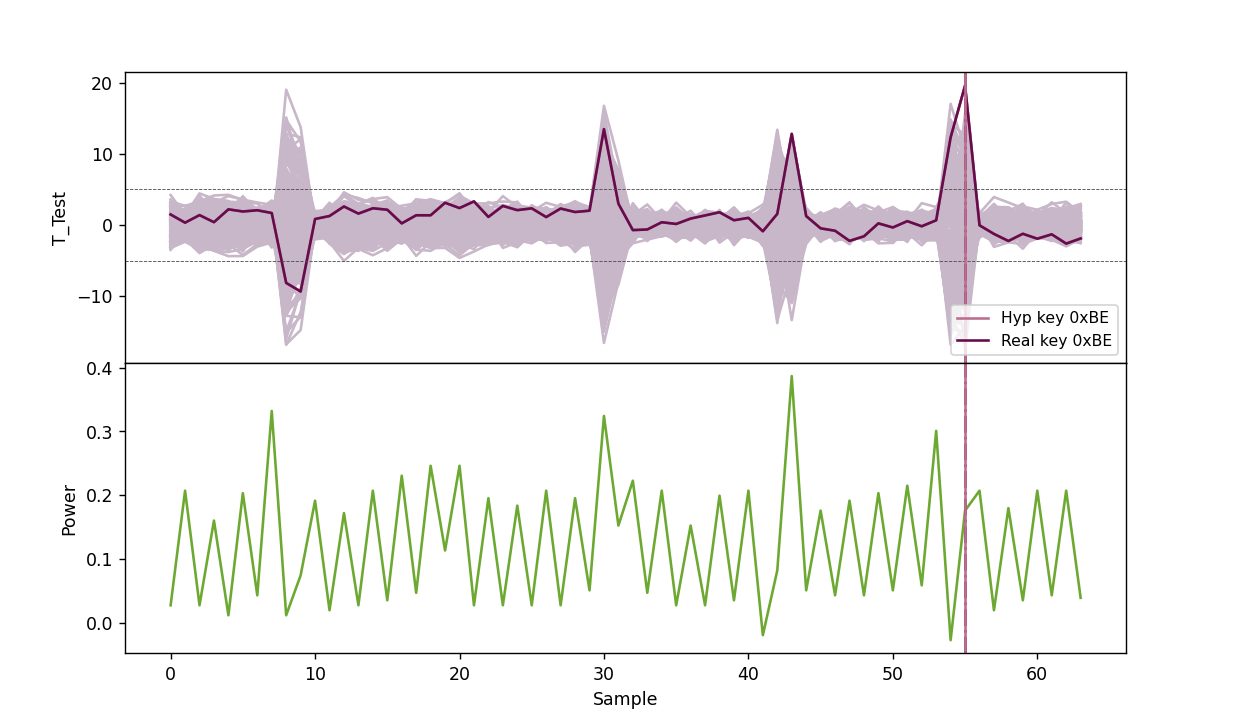

In [165]:
plt_time_dpa(key_hyp_DPA, time_dpa_array, trace_selected_DPA_10_000) #plt_time_corr(key_hyp, correla_array, s_trace)

<IPython.core.display.Javascript object>


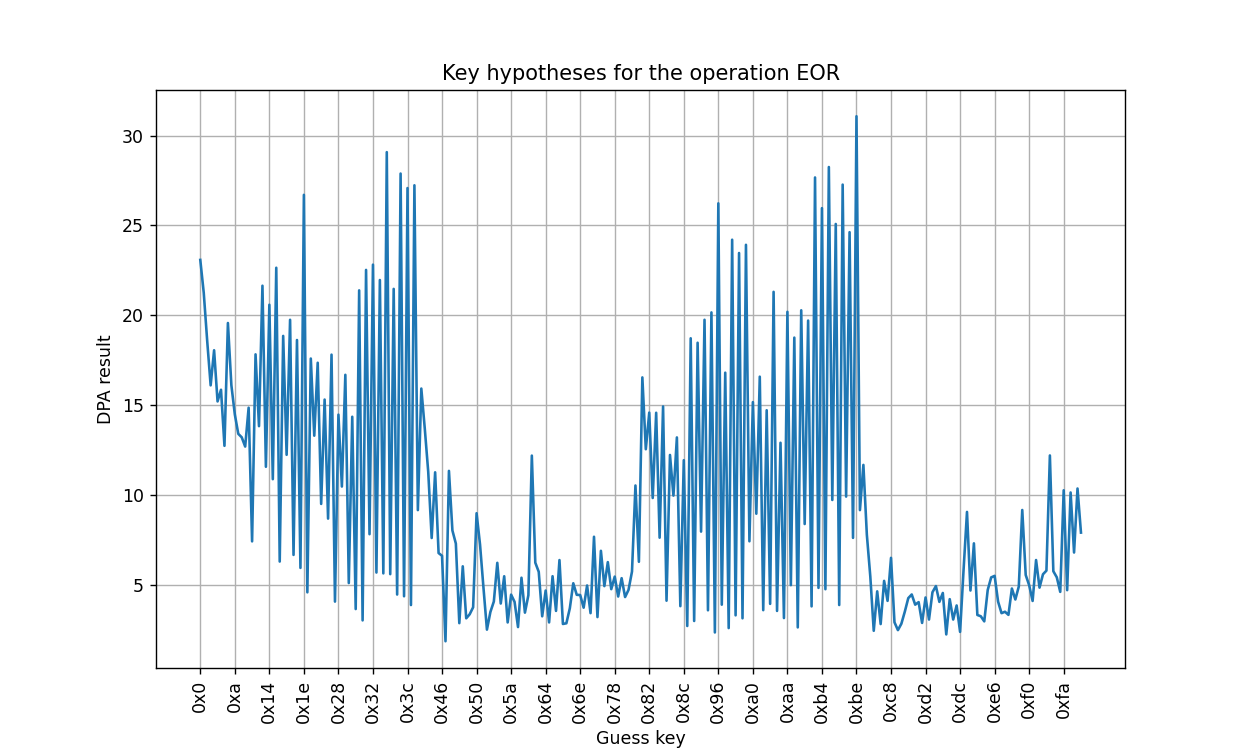

In [123]:
###### Figure confs
font = font_manager.FontProperties(style='normal', size=5)
plt.rcParams['figure.figsize']=(10,6)
plt.figure();
plt.xlabel('Guess key')
plt.ylabel('DPA result')
plt.grid(True)
plt.title('Key hypotheses for the operation EOR')
###### The hex values for the x-axis every 10 samples
x_hex = [hex(i) for i in range(len(ttest_diffs))]
x_ticks = range(0, len(ttest_diffs), 10)
x_hex_ticks = [x_hex[i] for i in x_ticks]
plt.xticks(x_ticks, x_hex_ticks, rotation='vertical')
###### Figure confs end 
plt.plot(ttest_diffs) 
plt.show();

##  Tests